In [3]:
!pip install numpy pandas
import pandas as pd
import numpy as np
# Load dataset
df = pd.read_csv("data/cleaned_clinical_drugs_dataset.csv")

# Drop duplicates to avoid redundant triples
df = df.drop_duplicates(subset=["drug_name", "efo_term", "target", "mechanism_of_action"])
df = df.fillna("Unknown")  # Replace NaN
df.head()


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlflow 2.15.1 requires numpy<2, but you have numpy 2.3.1 which is incompatible.
mlflow 2.15.1 requires pyarrow<16,>=4.0.0, but you have pyarrow 20.0.0 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.3.1 which is incompatible.
scikit-learn 1.3.2 requires numpy<2.0,>=1.17.3, but you have numpy 2.3.1 which is incompatible.
scipy 1.14.1 requires numpy<2.3,>=1.23.5, but you have numpy 2.3.1 which is incompatible.
sentence-transformers 3.4.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.40.1 which is incompatible.
streamlit 1.44.0 requires packaging<25,>=20, but you have packaging 25.0 which is incompatible.
tensorflow-intel 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.3.1 which is incompatible.
torchvision 0.20.1 requires torch==2.5.1, but you have t

  Using cached numpy-2.3.1-cp312-cp312-win_amd64.whl.metadata (60 kB)
Using cached numpy-2.3.1-cp312-cp312-win_amd64.whl (12.7 MB)


,drug_id,drug_name,SMILES,logD,logP,psa,drug_likeness,max_phase,IC50,target,organism,target_type,mechanism_of_action,efo_term,efo_id,mesh_heading,mesh_id,toxicity_alert,pIC50
0,CHEMBL223228,EFAVIRENZ,O=C1Nc2ccc(Cl)cc2[C@@](C#CC2CC2)(C(F)(F)F)O1,4.46,4.46,38.33,0.73,4.0,0.75,Human immunodeficiency virus type 1 reverse tr...,Human immunodeficiency virus 1,SINGLE PROTEIN,Human immunodeficiency virus type 1 reverse tr...,AIDS,EFO:0000765,Acquired Immunodeficiency Syndrome,D000163,triple bond,9.124939
1,CHEMBL223228,EFAVIRENZ,O=C1Nc2ccc(Cl)cc2[C@@](C#CC2CC2)(C(F)(F)F)O1,4.46,4.46,38.33,0.73,4.0,0.75,Human immunodeficiency virus type 1 reverse tr...,Human immunodeficiency virus 1,SINGLE PROTEIN,Human immunodeficiency virus type 1 reverse tr...,immunodeficiency disease,MONDO:0021094,Autoimmune Diseases,D001327,triple bond,9.124939
2,CHEMBL223228,EFAVIRENZ,O=C1Nc2ccc(Cl)cc2[C@@](C#CC2CC2)(C(F)(F)F)O1,4.46,4.46,38.33,0.73,4.0,0.75,Human immunodeficiency virus type 1 reverse tr...,Human immunodeficiency virus 1,SINGLE PROTEIN,Human immunodeficiency virus type 1 reverse tr...,type 2 diabetes mellitus,MONDO:0005148,"Diabetes Mellitus, Type 2",D003924,triple bond,9.124939
3,CHEMBL223228,EFAVIRENZ,O=C1Nc2ccc(Cl)cc2[C@@](C#CC2CC2)(C(F)(F)F)O1,4.46,4.46,38.33,0.73,4.0,0.75,Human immunodeficiency virus type 1 reverse tr...,Human immunodeficiency virus 1,SINGLE PROTEIN,Human immunodeficiency virus type 1 reverse tr...,hepatitis C virus infection,EFO:0003047,Hepatitis C,D006526,triple bond,9.124939
4,CHEMBL223228,EFAVIRENZ,O=C1Nc2ccc(Cl)cc2[C@@](C#CC2CC2)(C(F)(F)F)O1,4.46,4.46,38.33,0.73,4.0,0.75,Human immunodeficiency virus type 1 reverse tr...,Human immunodeficiency virus 1,SINGLE PROTEIN,Human immunodeficiency virus type 1 reverse tr...,infection,EFO:0000544,Infections,D007239,triple bond,9.124939


In [4]:
triples = []

for _, row in df.iterrows():
    drug = row["drug_name"].strip().upper()

    triples.append((drug, "treats", row["efo_term"]))
    triples.append((drug, "targets", row["target"]))
    triples.append((drug, "has_moa", row["mechanism_of_action"]))
    triples.append((drug, "has_warning", row["toxicity_alert"]))
    triples.append((drug, "has_mesh", row["mesh_heading"]))
    triples.append((drug, "has_logP", str(row["logP"])))
    triples.append((drug, "has_IC50", str(row["IC50"])))


In [5]:
kg_df = pd.DataFrame(triples, columns=["head", "relation", "tail"])
kg_df.drop_duplicates().to_csv("pharmasage_kg_triples.csv", index=False)
print("✅ Saved KG as pharmasage_kg_triples.csv")


✅ Saved KG as pharmasage_kg_triples.csv


In [6]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

kg_df = pd.read_csv("pharmasage_kg_triples.csv")

G = nx.MultiDiGraph()

for _, row in kg_df.iterrows():
    G.add_edge(row["head"], row["tail"], label=row["relation"])


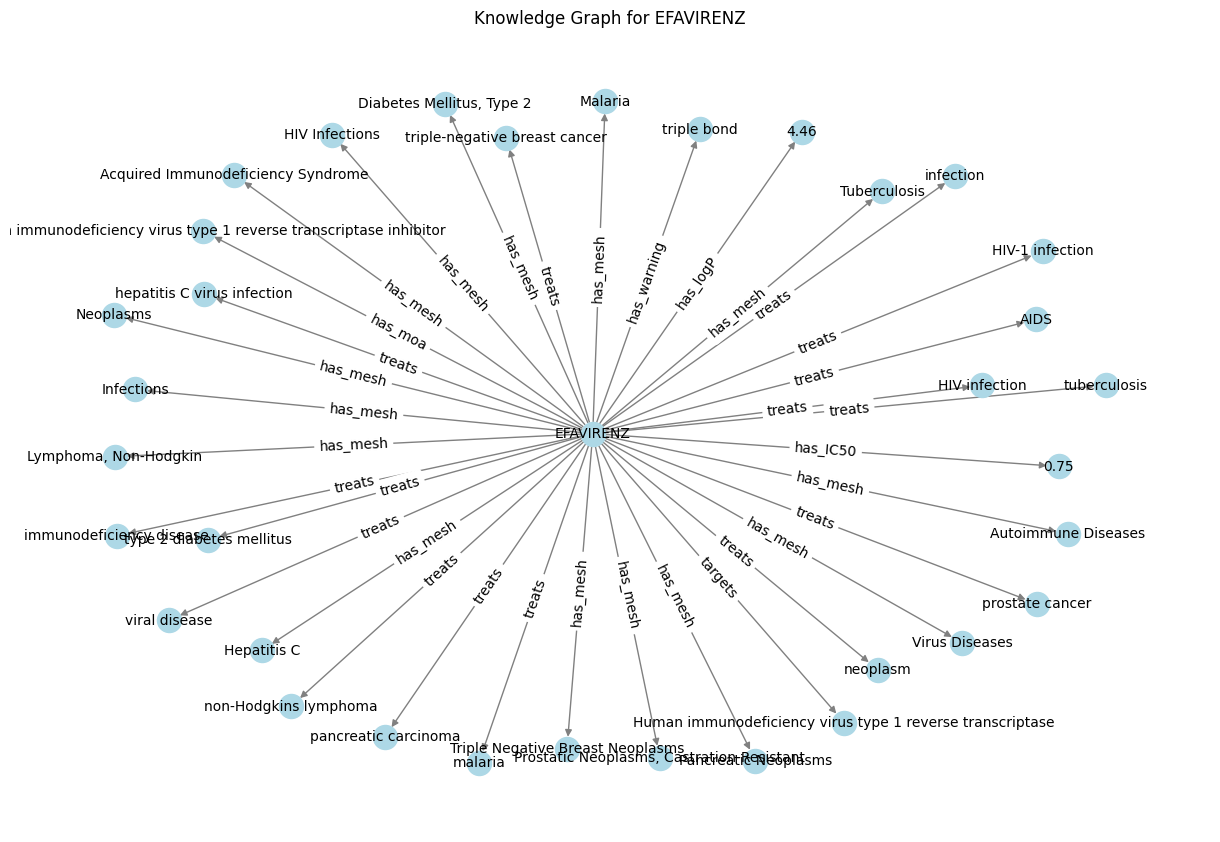

In [7]:
# Filter for 1 drug (e.g., EFAVIRENZ)
sub_nodes = set()
target_drug = "EFAVIRENZ"
for _, row in kg_df[kg_df["head"] == target_drug].iterrows():
    sub_nodes.add(row["head"])
    sub_nodes.add(row["tail"])

subgraph = G.subgraph(sub_nodes)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph, seed=42)
nx.draw(subgraph, pos, with_labels=True, node_color='lightblue', edge_color='gray', font_size=10)
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels={(u, v): d["label"] for u, v, d in subgraph.edges(data=True)})
plt.title(f"Knowledge Graph for {target_drug}")
plt.show()


In [9]:
# 📌 Step 1: Import Libraries
import pandas as pd

# 📌 Step 2: Load your cleaned dataset (adjust path if needed)
df = pd.read_csv('data/cleaned_clinical_drugs_dataset.csv')  # replace with your actual filename

# 📌 Step 3: Define a relation mapping for KG construction
relation_map = {
    'logP': 'logP_value',
    'logD': 'logD_value',
    'psa': 'psa_value',
    'IC50': 'binding_affinity_IC50',
    'pIC50': 'binding_affinity_pIC50',
    'toxicity_alert': 'has_toxicity',
    'drug_likeness': 'drug_likeness_score',
    'max_phase': 'approved_phase',
    'target': 'targets',
    'organism': 'in_organism',
    'target_type': 'target_type',
    'mechanism_of_action': 'mechanism_of_action',
    'efo_term': 'treats',
    'mesh_heading': 'associated_with_mesh'
}

# 📌 Step 4: Generate KG triples from each row
triples = []

for _, row in df.iterrows():
    drug = row['drug_name'].strip()

    for col, relation in relation_map.items():
        value = row[col]
        if pd.notna(value):
            triples.append((drug, relation, str(value).strip()))

# 📌 Step 5: Save to CSV for review/use later
triples_df = pd.DataFrame(triples, columns=["head", "relation", "tail"])
triples_df.to_csv('data/pharmasage_kg_triples_cleaned.csv', index=False)

# ✅ Done
print(f"✅ KG Triples saved: {len(triples_df)}")
triples_df.head()


✅ KG Triples saved: 7704887


,head,relation,tail
0,EFAVIRENZ,logP_value,4.46
1,EFAVIRENZ,logD_value,4.46
2,EFAVIRENZ,psa_value,38.33
3,EFAVIRENZ,binding_affinity_IC50,0.75
4,EFAVIRENZ,binding_affinity_pIC50,9.1249387366083


In [ ]:
# 📌 Step 6: Load the cleaned triples
triples_df = pd.read_csv('data/pharmasage_kg_triples_cleaned.csv')

# 📌 Step 7: Define natural language templates for each relation
nl_templates = {
    'logP_value': "{} has a logP of {}.",
    'logD_value': "{} has a logD of {}.",
    'psa_value': "{} has a polar surface area (PSA) of {}.",
    'binding_affinity_IC50': "{} has an IC50 value of {} μM.",
    'binding_affinity_pIC50': "{} has a pIC50 value of {}.",
    'has_toxicity': "{} has a known toxicity alert: {}.",
    'drug_likeness_score': "{} has a drug-likeness score of {}.",
    'approved_phase': "{} is approved up to phase {} in clinical trials.",
    'targets': "{} targets {}.",
    'in_organism': "{} is studied in the organism {}.",
    'target_type': "{} interacts with a target of type {}.",
    'mechanism_of_action': "The mechanism of action for {} is '{}'.",
    'treats': "{} is used to treat {}.",
    'associated_with_mesh': "{} is associated with the MeSH heading '{}'."
}

# 📌 Step 8: Generate sentences
sentences = []
for _, row in triples_df.iterrows():
    drug, relation, tail = row['head'], row['relation'], row['tail']
    if relation in nl_templates:
        sentence = nl_templates[relation].format(drug, tail)
        sentences.append(sentence)

# 📌 Step 9: Save sentences for RAG indexing
sentences_df = pd.DataFrame(sentences, columns=["text"])
sentences_df.to_csv("data/pharmasage_rag_facts.csv", index=False)

# ✅ Output a few samples
print(f"✅ RAG facts saved: {len(sentences_df)}")
sentences_df.sample(5)
sentence_df.head()[1]

In [4]:
import pandas as pd
sentence_df = pd.read_csv('data/pharmasage_rag_facts.csv')

In [7]:
sentence_df.head()

,text
0,EFAVIRENZ has a logP of 4.46.
1,EFAVIRENZ has a logD of 4.46.
2,EFAVIRENZ has a polar surface area (PSA) of 38...
3,EFAVIRENZ has an IC50 value of 0.75 μM.
4,EFAVIRENZ has a pIC50 value of 9.1249387366083.


In [10]:
triplets_df = pd.read_csv('data/pharmasage_kg_triples_cleaned.csv')
triplets_df.head(30)

,head,relation,tail
0,EFAVIRENZ,logP_value,4.46
1,EFAVIRENZ,logD_value,4.46
2,EFAVIRENZ,psa_value,38.33
3,EFAVIRENZ,binding_affinity_IC50,0.75
4,EFAVIRENZ,binding_affinity_pIC50,9.1249387366083
5,EFAVIRENZ,has_toxicity,triple bond
6,EFAVIRENZ,drug_likeness_score,0.73
7,EFAVIRENZ,approved_phase,4.0
8,EFAVIRENZ,targets,Human immunodeficiency virus type 1 reverse tr...
9,EFAVIRENZ,in_organism,Human immunodeficiency virus 1


In [11]:
!pip install pandas networkx pyvis


In [14]:
import pandas as pd
import networkx as nx
from pyvis.network import Network

# Load the cleaned triples CSV
df = pd.read_csv('data/pharmasage_kg_triples_cleaned.csv')

# Filter for one drug (you can change this to 'ASPIRIN' etc.)
drug_name = "EFAVIRENZ"
subgraph_df = df[df['head'] == drug_name]

# Build directed graph
G = nx.DiGraph()

# Add edges with relation as label
for _, row in subgraph_df.iterrows():
    src = row['head']
    relation = row['relation']
    dst = row['tail']
    G.add_node(src)
    G.add_node(dst)
    G.add_edge(src, dst, label=relation)


In [15]:
# Initialize PyVis network
net = Network(height='600px', width='100%', directed=True, notebook=True)
net.from_nx(G)

# Customize edge labels
for edge in net.edges:
    edge['title'] = edge['label']

# Highlight central node
net.get_node(drug_name)['color'] = 'orange'
net.get_node(drug_name)['shape'] = 'dot'
net.get_node(drug_name)['size'] = 25

# Save and show in notebook
net.show('efavirenz_kg.html')


efavirenz_kg.html


In [17]:
import pandas as pd
import networkx as nx
from pyvis.network import Network

# Load KG
df = pd.read_csv('data/pharmasage_kg_triples_cleaned.csv')

# Filter for a single drug
drug_name = "EFAVIRENZ"
df_filtered = df[df['head'] == drug_name].drop_duplicates()

# Limit number of relations to visualize
df_sampled = df_filtered.head(15)  # Change 15 to more/less if needed

# Build simple graph
G = nx.DiGraph()
for _, row in df_sampled.iterrows():
    G.add_node(row['head'])
    G.add_node(row['tail'])
    G.add_edge(row['head'], row['tail'], label=row['relation'])


In [18]:
# Visualize
net = Network(height='500px', width='100%', directed=True, notebook=True)
net.from_nx(G)

# Edge labels on hover
for edge in net.edges:
    edge['title'] = edge['label']

# Highlight drug node
net.get_node(drug_name)['color'] = 'orange'
net.get_node(drug_name)['size'] = 30
net.get_node(drug_name)['shape'] = 'dot'

# Show result
net.show("clean_kg_efavirenz.html")


clean_kg_efavirenz.html


In [21]:
import pandas as pd

# Load your full dataset
df = pd.read_csv("data/cleaned_clinical_drugs_dataset.csv")

# Deduplicate rows
df = df.drop_duplicates()

# Prepare triplets list
triplets = []

for _, row in df.iterrows():
    drug = str(row['drug_name']).strip()
    
    # 1. binds_to relation
    if pd.notna(row['target']):
        target = str(row['target']).strip()
        triplets.append((drug, "binds_to", target))
    
    # 2. treats relation
    if pd.notna(row['efo_term']):
        disease = str(row['efo_term']).strip()
        triplets.append((drug, "treats", disease))
    
    # 3. has_mechanism relation (optional)
    if pd.notna(row['mechanism_of_action']):
        mech = str(row['mechanism_of_action']).strip()
        triplets.append((drug, "has_mechanism", mech))

# Convert to DataFrame
kg_df = pd.DataFrame(triplets, columns=["subject", "relation", "object"])

# Remove duplicates
kg_df = kg_df.drop_duplicates()

# Save as CSV
kg_df.to_csv("data/kg_triplets.csv", index=False)

print(f"✅ KG Triplet file saved with {len(kg_df)} rows.")


✅ KG Triplet file saved with 11758 rows.
